# <center> Amazon.com - Employee Access Challenge

Эти данные состоят из реальных исторических данных, собранных в 2010 и 2011 годах. Сотрудникам со временем вручную разрешают или запрещают доступ к ресурсам. Вы должны создать алгоритм, способный извлекать уроки из этих исторических данных, чтобы предсказать одобрение / отказ для невидимого набора сотрудников.

Когда сотрудник в любой компании начинает работать, ему сначала нужно получить доступ к компьютеру, необходимый для выполнения своей роли. Этот доступ может позволить сотруднику читать / манипулировать ресурсами через различные приложения или веб-порталы. Предполагается, что сотрудники, выполняющие функции данной роли, будут иметь доступ к тем же или подобным ресурсам. Часто бывает так, что сотрудники выясняют, какой доступ им нужен, поскольку они сталкиваются с препятствиями во время своей повседневной работы (например, не могут войти в портал отчетности). Хорошо осведомленный супервизор затем занимает время, чтобы вручную предоставить необходимый доступ для преодоления препятствий доступа. Поскольку сотрудники перемещаются по всей компании, этот цикл обнаружения/восстановления доступа тратит нетривиальное количество времени и денег.

Существует значительный объем данных, касающихся роли сотрудника в организации и ресурсов, к которым он имеет доступ. Учитывая данные, связанные с текущими сотрудниками и их предоставленным доступом, можно построить модели, которые автоматически определяют права доступа, когда сотрудники входят и выходят из ролей в компании. Эти модели автоматического доступа стремятся свести к минимуму участие человека, необходимое для предоставления или отмены доступа сотрудников.

**Цель**

Цель этого конкурса-построить модель, изученную с использованием исторических данных, которая определит потребности доступа сотрудника, такие что транзакции ручного доступа (гранты и отзывы) минимизируются, поскольку атрибуты сотрудника изменяются с течением времени. Модель будет принимать информацию о роли сотрудника и код ресурса и будет возвращать, должен ли быть предоставлен доступ или нет.

https://www.kaggle.com/c/amazon-employee-access-challenge/overview

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib 
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split 

Using matplotlib backend: Qt5Agg


In [17]:
import sklearn.metrics as metrics

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

In [61]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

**Признаки:**

- ACTION ACTION - Действие равно 1, если ресурс был одобрен, 0, если ресурс не был одобрен
- RESOURCE - Идентификатор для каждого ресурса
- MGR_ID - Идентификатор сотрудника менеджера текущей записи идентификатора сотрудника; у сотрудника может быть только один менеджер одновременно
- ROLE_ROLLUP_1 - Роль категории Группы компаний ИД 1 (например, US Engineering)
- ROLE_ROLLUP_2 - Группа ролей компании категория id 2 (например, US Retail)
- ROLE_DEPTNAME - Описание отдела роли компании (например, Retail)
- ROLE_TITLE - Роль компании описание названия бизнеса (например, Senior Engineering Retail Manager)
- ROLE_FAMILY_DESC - Расширенное описание семейства ролей компании (например, Retail Manager, Software Engineering)
- ROLE_FAMILY - Описание семьи ролей компании (например, Retail Manager)
- ROLE_CODE - Код роли компании; этот код уникален для каждой роли (например, менеджер)

In [6]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


**Посмотрим на число пропусков в каждом признаке.**

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
ACTION              32769 non-null int64
RESOURCE            32769 non-null int64
MGR_ID              32769 non-null int64
ROLE_ROLLUP_1       32769 non-null int64
ROLE_ROLLUP_2       32769 non-null int64
ROLE_DEPTNAME       32769 non-null int64
ROLE_TITLE          32769 non-null int64
ROLE_FAMILY_DESC    32769 non-null int64
ROLE_FAMILY         32769 non-null int64
ROLE_CODE           32769 non-null int64
dtypes: int64(10)
memory usage: 2.5 MB


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
id                  58921 non-null int64
RESOURCE            58921 non-null int64
MGR_ID              58921 non-null int64
ROLE_ROLLUP_1       58921 non-null int64
ROLE_ROLLUP_2       58921 non-null int64
ROLE_DEPTNAME       58921 non-null int64
ROLE_TITLE          58921 non-null int64
ROLE_FAMILY_DESC    58921 non-null int64
ROLE_FAMILY         58921 non-null int64
ROLE_CODE           58921 non-null int64
dtypes: int64(10)
memory usage: 4.5 MB


In [19]:
train_df.isnull().any().any()

False

Как мы можем заметить пропусков нет

In [11]:
train_df.shape

(32769, 10)

In [14]:
train_df.describe()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,0.942110,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893,119789.430132
std,0.233539,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413,5784.275516
min,0.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000,117880.000000
25%,1.000000,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000,118232.000000
50%,1.000000,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000,118570.000000
75%,1.000000,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000,119348.000000
max,1.000000,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000,270691.000000


**Построим для каждой количественной переменной гистограмму**

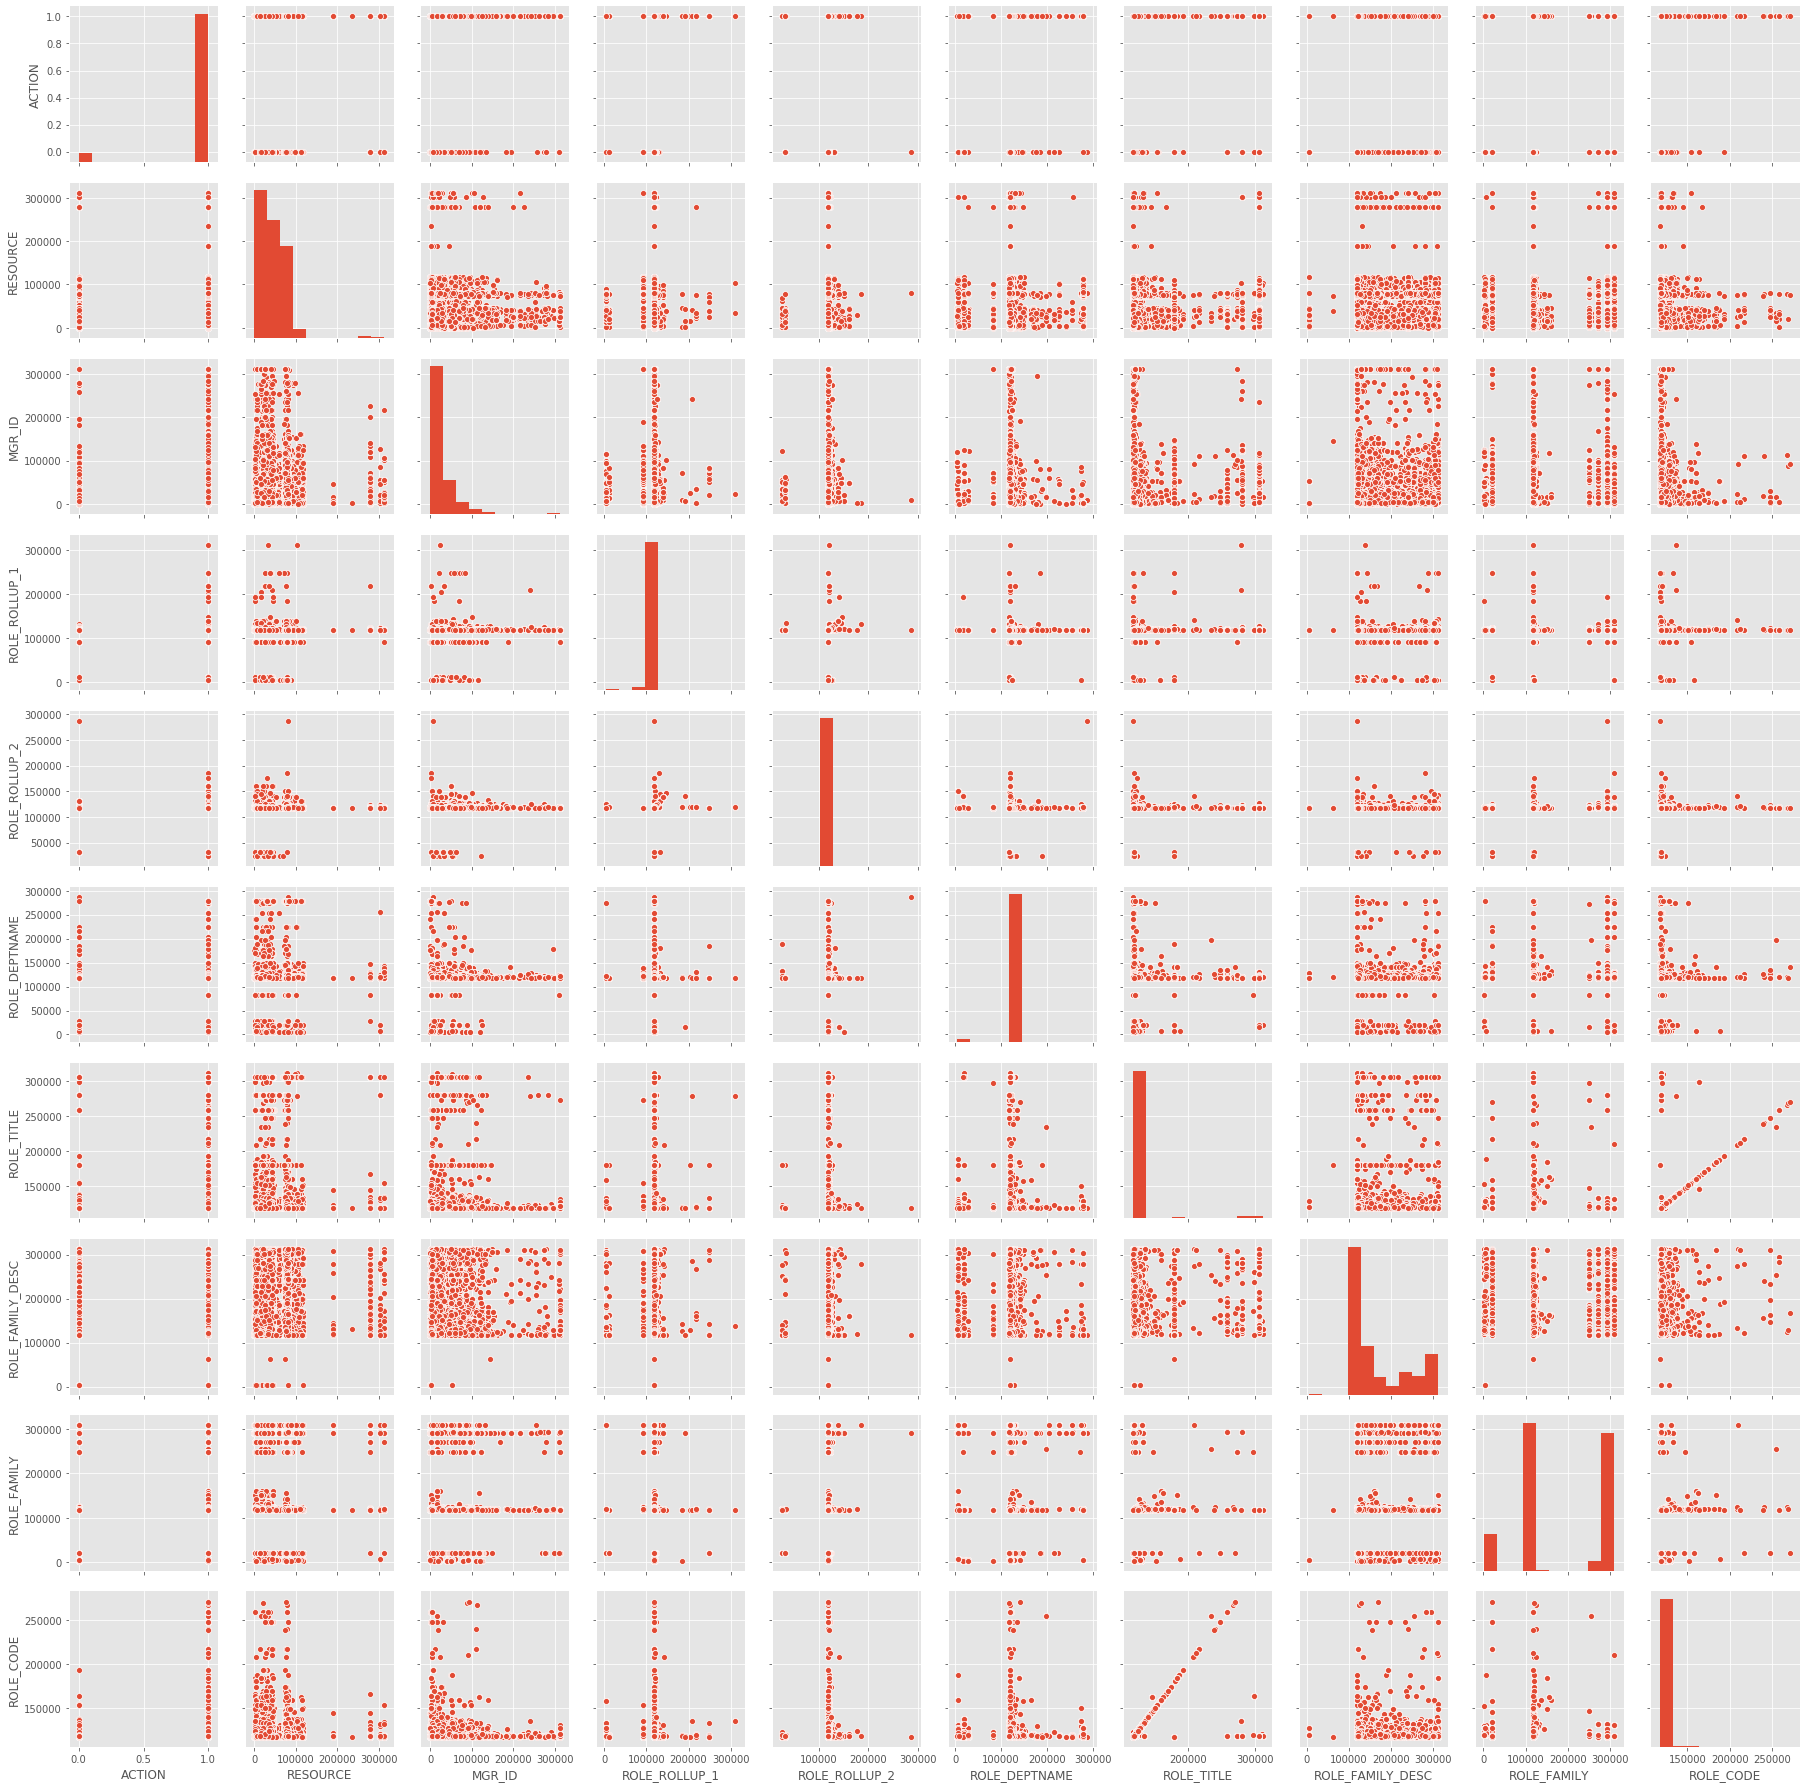

In [98]:
sns_plot = sns.pairplot(train_df)
sns_plot.savefig('pairplot.png')

In [30]:
train_df.corr()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
ACTION,1.000000,0.000185,-0.005167,-0.013702,0.005179,0.001025,-0.010169,0.003565,0.000502,0.017147
RESOURCE,0.000185,1.000000,0.011088,-0.005016,0.013438,0.030004,0.002936,0.021029,0.031060,0.007733
MGR_ID,-0.005167,0.011088,1.000000,-0.007132,-0.000364,-0.009551,0.017864,-0.018488,-0.118254,-0.004067
ROLE_ROLLUP_1,-0.013702,-0.005016,-0.007132,1.000000,0.033358,-0.009548,0.010207,-0.007546,0.029468,-0.024927
ROLE_ROLLUP_2,0.005179,0.013438,-0.000364,0.033358,1.000000,-0.006056,0.008305,0.018873,0.069558,0.015117
ROLE_DEPTNAME,0.001025,0.030004,-0.009551,-0.009548,-0.006056,1.000000,-0.006932,-0.002877,0.031669,0.010319
ROLE_TITLE,-0.010169,0.002936,0.017864,0.010207,0.008305,-0.006932,1.000000,0.170692,-0.012450,0.155920
ROLE_FAMILY_DESC,0.003565,0.021029,-0.018488,-0.007546,0.018873,-0.002877,0.170692,1.000000,-0.180596,0.092980
ROLE_FAMILY,0.000502,0.031060,-0.118254,0.029468,0.069558,0.031669,-0.012450,-0.180596,1.000000,-0.148625
ROLE_CODE,0.017147,0.007733,-0.004067,-0.024927,0.015117,0.010319,0.155920,0.092980,-0.148625,1.000000


**Из построенных диаграмм видно, что признаки не сильно коррелируют между собой, что впрочем можно также легко установить, посмотрев на корреляционную матрицу. Все ее недиагональные значения по модулю не превосходят 0.2**

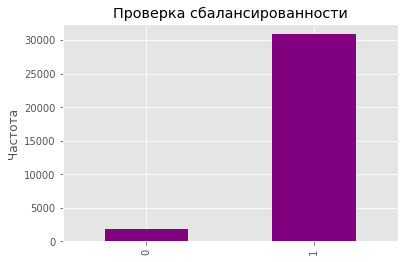

In [115]:
count_class = pd.value_counts(train_df.iloc[:, [0]].values.ravel(), sort= True).sort_index()
count_class.plot(kind = "bar", color = "Purple")
plt.ylabel("Частота")
plt.xticks(np.arange(2), ('0', '1'))
plt.title("Проверка сбалансированности")
plt.show()

**Как мы можем заметить, выборка не сбалансированная**

Cбалансируем выборку используя метод SMOTE

In [21]:
X_train = train_df.drop(('ACTION'), axis=1) 
y_train = train_df['ACTION']

In [69]:
test_df=test_df.drop(('id'), axis=1)

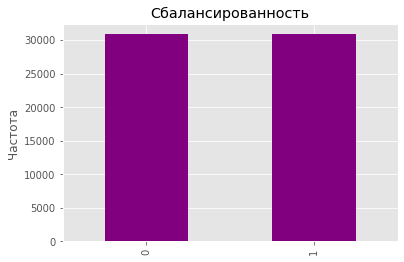

In [35]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, kind='borderline1')
X_balanced, Y_balanced = sm.fit_sample(train_df, train_df.iloc[:, [0]].values.ravel())

count_class = pd.value_counts(Y_balanced, sort= True).sort_index()
count_class.plot(kind = "bar", color = "purple")
plt.ylabel("Частота")
plt.xticks(np.arange(2), ('0', '1'))
plt.title("Cбалансированность")
plt.show()


In [36]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_balanced, Y_balanced, test_size=0.3) 

**Метод ближайших соседей**

не сбалансированная выборка

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [25]:
y_train_predict = knn.predict(X_train)
err_train = np.mean(y_train != y_train_predict)
print(err_train)

0.051225041415990935


Деревья решений(non-bakanced)

In [26]:
tree=DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=17) 
tree.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

In [27]:
tree.score(X_train, y_train)

0.9436306565524457

In [31]:
a = np.zeros((10,10),dtype=float)
for depth in range(1,11):
    for leaf in range(1,11):
        tree=DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf)
        tree.fit(X_train, y_train)
        a[depth-1,leaf-1]=tree.score(X_train, y_train)
df = pd.DataFrame(data=a, index=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], 
                  columns=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
df

,1,2,3,4,5,6,7,8,9,10
1,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846
2,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846
3,0.942890,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846
4,0.942933,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846,0.942846
5,0.943979,0.943805,0.943805,0.943805,0.943805,0.943805,0.943761,0.943718,0.943718,0.943718
6,0.944939,0.944982,0.944895,0.944808,0.944721,0.944590,0.944546,0.944459,0.944415,0.944285
7,0.946421,0.946464,0.946290,0.945941,0.945767,0.945418,0.945418,0.945200,0.944939,0.944546
8,0.949080,0.949124,0.948513,0.947903,0.947772,0.947249,0.946813,0.946421,0.946159,0.945767
9,0.951827,0.951434,0.950562,0.949603,0.949211,0.948426,0.947903,0.947554,0.947249,0.946595
10,0.954791,0.953396,0.952306,0.951216,0.950562,0.949603,0.949385,0.948339,0.947685,0.946857


In [57]:
tree=DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=17, min_samples_leaf=leaf) 
tree.fit(X_train, y_train)
tree.score(X_train, y_train)

0.9458497521291471

In [70]:
first_tree_pred = tree.predict(test_df)

In [82]:
def write_to_submission_file(predicted_labels, out_file,
                             target='ACTION', index_label="Id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, 
                                                  predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [83]:
write_to_submission_file(first_tree_pred, 'amazon_tree.csv')

Result: 0.53826

Если предсказывать вероятности дефолта для клиентов тестовой выборки, результат будет намного лучше.

In [84]:
first_tree_pred = tree.predict_proba(test_df)[:, 1]

In [85]:
write_to_submission_file(first_tree_pred, 'amazon_tree2.csv')

Result: 0.65981

roc

In [54]:
pred_prob = tree.predict_proba(X_test)
preds = pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

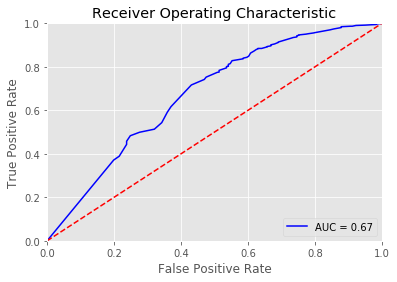

In [55]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [58]:
y_score = tree.predict(X_test)
print(metrics.accuracy_score(y_test, y_score))
print(metrics.recall_score(y_test, y_score))
print(metrics.precision_score(y_test, y_score))

0.9386120996441281
0.9858978376684425
0.9510278113663845
